In [1]:
import os
import platform
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# Check which platform is running the notebook
if platform.system() == 'Windows':
    PROJECT_PATH = "\\".join(os.getcwd().split('\\')[:-1])
else:
    # Assuming a Unix based platform
    PROJECT_PATH = "/".join(os.getcwd().split('/')[:-1])

DATA_PATH = os.path.join(PROJECT_PATH, 'data')
TRAIN_DATA_PATH = os.path.join(DATA_PATH, 'train.csv')

train_data = pd.read_csv(TRAIN_DATA_PATH)
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Training & Testing Sets

In [2]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
target_label = 'SalePrice'

X = train_data.drop(target_label, axis=1)
y = train_data[target_label]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.3)
print('Train Size: ', X_train.shape)
print('Test Size: ', X_test.shape)

Train Size:  (1022, 80)
Test Size:  (438, 80)


In [3]:
# Create a copy to manipulate
X_train_df = X_train.copy()
X_train_df = X_train_df.drop('Id', axis=1)

In [4]:
from utils.core import *

X_train_df = remove_missing_features(X_train_df, verbose=True)

Alley         93.542%
PoolQC        99.511%
Fence         80.235%
MiscFeature   96.086%


## Numeric Features

In [5]:
numeric_features = X_train_df.select_dtypes(['int64', 'float64'])
numeric_cols = numeric_features.columns.tolist()
numeric_features.shape

(1022, 36)

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

numeric_pipeline = ColumnTransformer([
    ('process', Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())
    ]), numeric_cols)
])

In [7]:
from sklearn.ensemble import RandomForestRegressor

numeric_training = numeric_pipeline.fit_transform(numeric_features)

rand_forest = RandomForestRegressor(random_state=RANDOM_STATE)
scores = cross_val_regression(rand_forest, numeric_training, y_train)
print('Numeric Random Forest RMSE: {:.6f}'.format(scores['rmse']))
print('Numeric Random Forest RMSLE: {:6f}'.format(scores['rmlse']))

Numeric Random Forest RMSE: 31600.591887
Numeric Random Forest RMSLE: 0.153450


In [8]:
from sklearn.feature_selection import SelectKBest, f_regression

k_best_numeric = SelectKBest(score_func=f_regression, k=15)
k_best_numeric_data = k_best_numeric.fit_transform(numeric_training, y_train)

In [9]:
scores = cross_val_regression(rand_forest, k_best_numeric_data, y_train)
print('Numeric Random Forest k=15 RMSE: {:.6f}'.format(scores['rmse']))
print('Numeric Random Forest k=15 RMSLE: {:6f}'.format(scores['rmlse']))

Numeric Random Forest k=15 RMSE: 31748.538837
Numeric Random Forest k=15 RMSLE: 0.157814


From choosing the best 15 features, the performance of the model has slighly decreased. Trying PCA on the all the numeric values to see if the same scores are maintained

In [10]:
from sklearn.decomposition import PCA

pca = PCA(random_state=42, n_components=0.99)
pca_numeric = pca.fit_transform(numeric_training)

In [11]:
scores = cross_val_regression(rand_forest, pca_numeric, y_train)
print('Numeric Random Forest PCA RMSE: {:.6f}'.format(scores['rmse']))
print('Numeric Random Forest PCA RMSLE: {:6f}'.format(scores['rmlse']))

Numeric Random Forest PCA RMSE: 36132.672838
Numeric Random Forest PCA RMSLE: 0.170683


Try sampling the outliers to see if that improves overall accuracy

In [12]:
from sklearn.utils import resample

q1, q3 = y_train.quantile([0.25, 0.75])
iqr = q3 - q1
max_outliers = q3 + 1.5 * iqr

y_outliers = y_train[y_train > max_outliers]
X_outliers = numeric_features.loc[y_outliers.index]

n_samples = 500
X_resampled = resample(X_outliers, random_state=RANDOM_STATE, n_samples=n_samples)
y_resampled = resample(y_outliers, random_state=RANDOM_STATE, n_samples=n_samples)

In [13]:
X_sampled = pd.concat([numeric_features, X_resampled])
y_sampled = pd.concat([y_train, y_resampled])

In [14]:
X_sampled = X_sampled.reset_index(drop=True)
y_sampled = y_sampled.reset_index(drop=True)

In [15]:
X_sampled_processed = numeric_pipeline.transform(X_sampled)

In [16]:
scores = cross_val_regression(rand_forest, X_sampled_processed, y_sampled)
print('Numeric Random Forest Resampled Outliers RMSE: {:.6f}'.format(scores['rmse']))
print('Numeric Random Forest Resampled Outliers RMSLE: {:6f}'.format(scores['rmlse']))

Numeric Random Forest Resampled Outliers RMSE: 33332.978522
Numeric Random Forest Resampled Outliers RMSLE: 0.136032


From resampling the outliers, we have managed to improve the overall result of the model when looking at the numeric features.

## Experiment - Scaling the target feature

Try scaling the target feature to see if that can improve the distribution of the data as well as improve the overall accuracy of the model

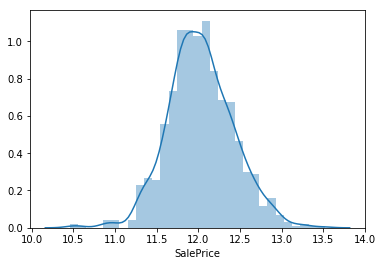

In [17]:
y_train_log = np.log1p(y_train)

sns.distplot(np.log1p(y_train))
plt.show()

In [18]:
scores = cross_val_regression(rand_forest, numeric_training, y_train_log)
print('Numeric Random Forest Resampled Outliers RMSE: {:.6f}'.format(scores['rmse']))
print('Numeric Random Forest Resampled Outliers RMSLE: {:6f}'.format(scores['rmlse']))

Numeric Random Forest Resampled Outliers RMSE: 0.151963
Numeric Random Forest Resampled Outliers RMSLE: 0.011731


Seems to perform fairly well but would need to experiment with returning the actual result to ensure it is working correclly.

### Creating a simple random forest model

In [19]:
rand_forest_v1 = RandomForestRegressor(random_state=RANDOM_STATE)
rand_forest_v1.fit(numeric_training, y_train_log)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [20]:
y_pred = rand_forest_v1.predict(numeric_training)
y_pred = np.exp(y_pred) - 1
print(y_pred)

[167309.95703817 143432.13756843 206152.50111663 ... 118086.72391505
 177296.753079   180446.29929771]


In [21]:
root_mean_squared_error(y_train, y_pred)

13047.920536507903

In [22]:
root_mean_log_error(y_train, y_pred)

0.056474456859730224

Seems to be rather promosing and has show far yeidled the smallest error rate when scaled back. Next I will try and create a simple pipeline to see if it can automatically scale it back

In [23]:
from sklearn.compose import TransformedTargetRegressor

transformer = TransformedTargetRegressor(regressor=RandomForestRegressor(random_state=RANDOM_STATE),
                                        func=np.log1p, inverse_func=lambda x: np.exp(x) - 1)

In [24]:
scores = cross_val_regression(transformer, numeric_training, y_train)
print('Numeric Random Forest Transformed RMSE: {:.6f}'.format(scores['rmse']))
print('Numeric Random Forest Transformed RMSLE: {:6f}'.format(scores['rmlse']))

Numeric Random Forest Transformed RMSE: 32222.193085
Numeric Random Forest Transformed RMSLE: 0.151963


By applying the transformation to the target, the RMSLE has a minor improvement for the overall error score.

## Categorical Features

Bringing in the baseline categorical values to see how it affects the baseline score

In [25]:
# Define the ordinal features
ordinal_cols = [
    'LotShape',
    'ExterQual',
    'ExterCond',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'HeatingQC',
    'KitchenQual',
    'FireplaceQu',
    'GarageQual',
    'GarageCond',
]

object_features = X_train_df.select_dtypes(['object'])
object_cols = object_features.columns

categorical_cols = object_cols[~object_cols.isin(ordinal_cols)].tolist()

In [26]:
ordinal_features = object_features[ordinal_cols]
categorical_features = object_features[categorical_cols]

Creating a basic pipeline with all the features and without removing the target feature outliers

In [27]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

numeric_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

ordinal_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

categorical_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

processing_pipeline = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_cols),
    ('ordinal', ordinal_pipeline, ordinal_cols),
    ('categorical', categorical_pipeline, categorical_cols)
])

In [28]:
X_train_processed = processing_pipeline.fit_transform(X_train)

In [29]:
scores = cross_val_regression(transformer, X_train_processed, y_train)
print('Baseline Random Forest Transformed RMSE: {:.6f}'.format(scores['rmse']))
print('Baseline Random Forest Transformed RMSLE: {:6f}'.format(scores['rmlse']))

Baseline Random Forest Transformed RMSE: 31823.891348
Baseline Random Forest Transformed RMSLE: 0.151121


By scaling the features, the RMSLE is slightly lower that the original baseline in the first notebook.

## Improving the result

In [30]:
from sklearn.feature_selection import SelectFromModel

# Try using an embedded approach first
s = SelectFromModel(estimator=rand_forest)
X_train_embedded = s.fit_transform(X_train_processed, y_train)

In [31]:
scores = cross_val_regression(transformer, X_train_embedded, y_train)
print('Random Forest Embedded RMSE: {:.6f}'.format(scores['rmse']))
print('Random Forest Embedded RMSLE: {:6f}'.format(scores['rmlse']))

Random Forest Embedded RMSE: 31978.098952
Random Forest Embedded RMSLE: 0.157491


Compared to using all the original data, this is close to the above score but has decreased in some performance.

### Looking into the numeric features

In [32]:
# See how unique each numeric value is

unique_threshold = 10

cols_below_threshold = []
for col in numeric_cols:
    numeric_data = numeric_features[col]
    if numeric_data.nunique() < unique_threshold:
        cols_below_threshold.append(col)
        
print('Found {} cols'.format(len(cols_below_threshold)))

Found 11 cols


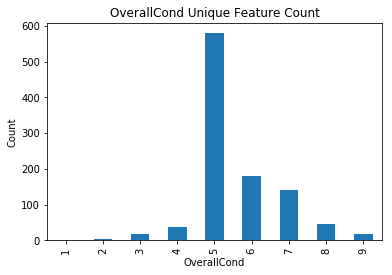

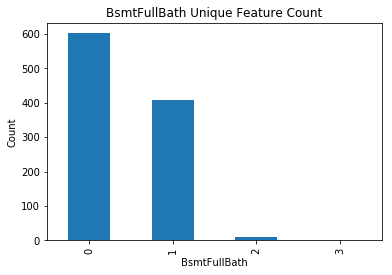

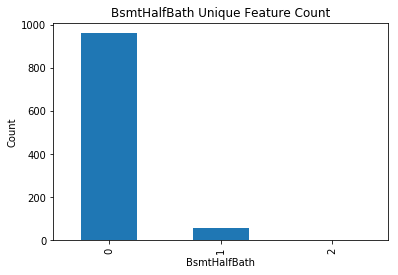

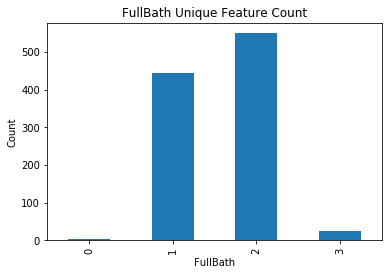

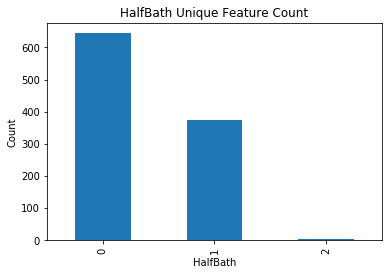

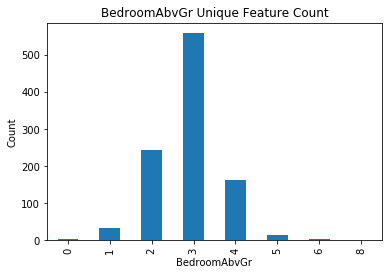

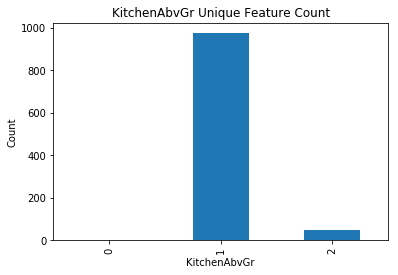

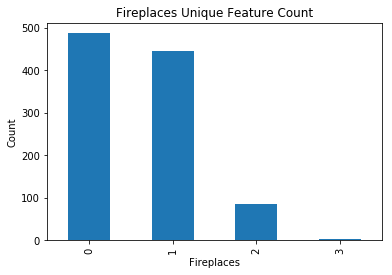

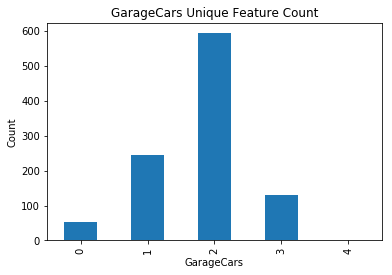

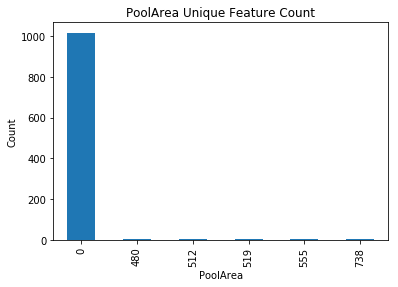

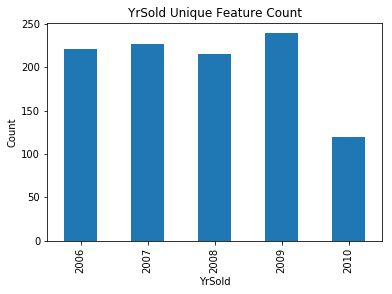

In [33]:
# Plot the columns

for col in cols_below_threshold:
    numeric_data = numeric_features[col]
    ax = numeric_data.value_counts().sort_index().plot(kind='bar')
    ax.set_title('{} Unique Feature Count'.format(col))
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    plt.show()

There is potential to remove a few features here as for some of them have a dominant value that appears. We can remove these features since they won't add any real value to the model

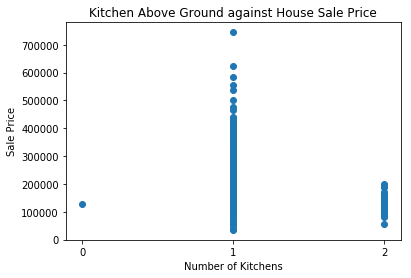

In [34]:
# plot kitchens above ground against sale price
plt.scatter(numeric_features.KitchenAbvGr, y_train)
plt.title('Kitchen Above Ground against House Sale Price')
plt.ylabel('Sale Price')
plt.xticks([0, 1, 2])
plt.xlabel('Number of Kitchens')
plt.show()

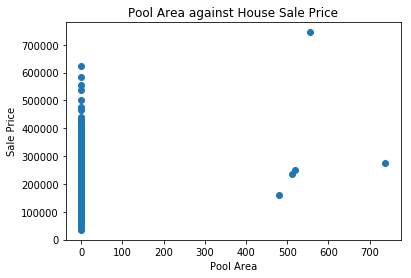

In [35]:
plt.scatter(numeric_features.PoolArea, y_train)
plt.xlabel('Pool Area')
plt.ylabel('Sale Price')
plt.title('Pool Area against House Sale Price')
plt.show()

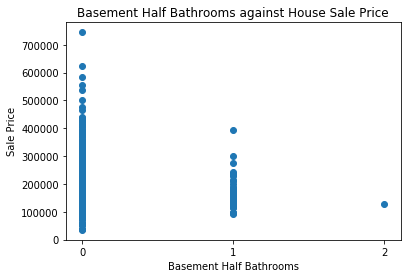

In [36]:
plt.scatter(numeric_features.BsmtHalfBath, y_train)
plt.xticks([0, 1, 2])
plt.xlabel('Basement Half Bathrooms')
plt.ylabel('Sale Price')
plt.title('Basement Half Bathrooms against House Sale Price')
plt.show()

Out of the numeric feautres, I will remove `BsmtHalfBath`, `PoolArea` and `KitchenAbvGr` since there doesn't seem to be a clear trend when plotting against the target feature and there is a single dominant feature.

In [37]:
numeric_features_refined = numeric_features.copy()
numeric_features_refined.drop(['BsmtHalfBath', 'PoolArea', 'KitchenAbvGr'], axis=1, inplace=True)

In [38]:
numeric_features_refined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1022 entries, 135 to 1126
Data columns (total 33 columns):
MSSubClass       1022 non-null int64
LotFrontage      832 non-null float64
LotArea          1022 non-null int64
OverallQual      1022 non-null int64
OverallCond      1022 non-null int64
YearBuilt        1022 non-null int64
YearRemodAdd     1022 non-null int64
MasVnrArea       1019 non-null float64
BsmtFinSF1       1022 non-null int64
BsmtFinSF2       1022 non-null int64
BsmtUnfSF        1022 non-null int64
TotalBsmtSF      1022 non-null int64
1stFlrSF         1022 non-null int64
2ndFlrSF         1022 non-null int64
LowQualFinSF     1022 non-null int64
GrLivArea        1022 non-null int64
BsmtFullBath     1022 non-null int64
FullBath         1022 non-null int64
HalfBath         1022 non-null int64
BedroomAbvGr     1022 non-null int64
TotRmsAbvGrd     1022 non-null int64
Fireplaces       1022 non-null int64
GarageYrBlt      968 non-null float64
GarageCars       1022 non-null int64

In [39]:
cols_with_missing_values = ['GarageYrBlt', 'MasVnrArea', 'LotFrontage']
numeric_features_refined[cols_with_missing_values]

,GarageYrBlt,MasVnrArea,LotFrontage
135,1970.0,288.0,80.0
1452,2005.0,80.0,35.0
762,2009.0,0.0,72.0
932,2006.0,302.0,84.0
435,1996.0,0.0,43.0
...,...,...,...
1095,2006.0,0.0,78.0
1130,1981.0,0.0,65.0
1294,1957.0,0.0,60.0
860,1925.0,0.0,55.0


For these 3 features, I assume that if they have missing values then it is down to the fact that these features are not present on the house. To resolve the missing values, I will impute them with zero instead to denote they don't have them.

Additionally, a feature for has garage can be built from this

In [40]:
numeric_features_refined.fillna(0, inplace=True)
scores = cross_val_regression(transformer, numeric_features_refined, y_train)
print('Random Forest Refined Numeric features RMSE: {:.6f}'.format(scores['rmse']))
print('Random Forest Refined Numeric features RMSLE: {:6f}'.format(scores['rmlse']))

Random Forest Refined Numeric features RMSE: 32069.236160
Random Forest Refined Numeric features RMSLE: 0.152867


Compared to the original baseline numeric model, there has been an improvement in RMSLE, previously it was 0.17 whereas not it is 0.15.

In [41]:
numeric_cols_v2 = numeric_features_refined.columns.tolist()

In [42]:
numeric_pipeline_v2 = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', MinMaxScaler())
])

processing_pipeline_v2 = ColumnTransformer([
    ('numeric', numeric_pipeline_v2, numeric_cols_v2),
    ('ordinal', ordinal_pipeline, ordinal_cols),
    ('categorical', categorical_pipeline, categorical_cols)
])

In [43]:
X_train_processed_v2 = processing_pipeline_v2.fit_transform(X_train)

In [44]:
scores = cross_val_regression(transformer, X_train_processed_v2, y_train)
print('Random Forest Pipeline V2 RMSE: {:.6f}'.format(scores['rmse']))
print('Random Forest Pipeline V2 features RMSLE: {:6f}'.format(scores['rmlse']))

Random Forest Pipeline V2 RMSE: 32040.924372
Random Forest Pipeline V2 features RMSLE: 0.151541


From imputing missing numeric values with zero and integrating that into a new pipeline, we have got a minor improvement in RMSLE and RMSE.

### Ordinal Features

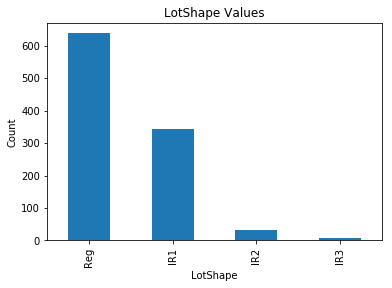

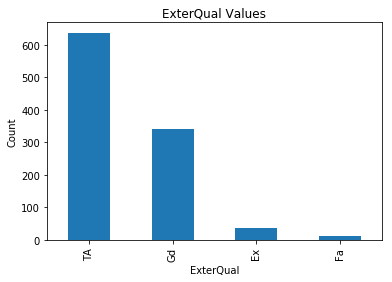

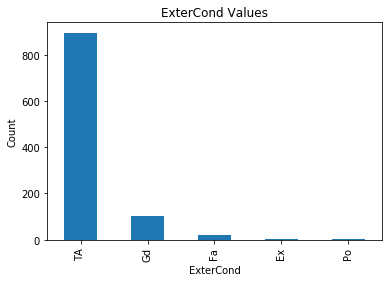

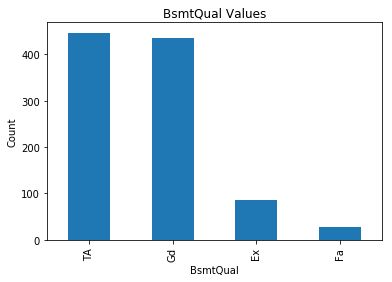

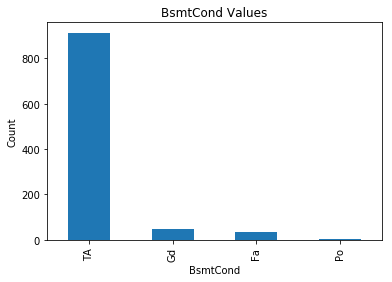

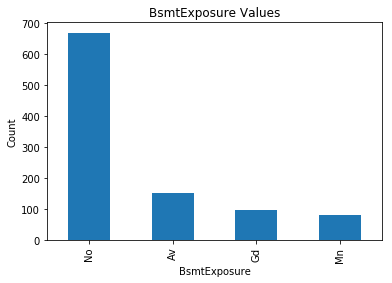

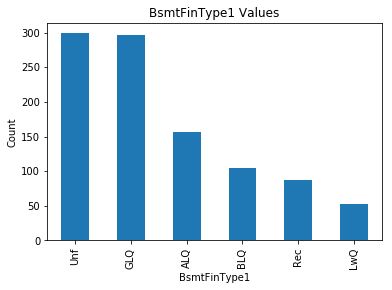

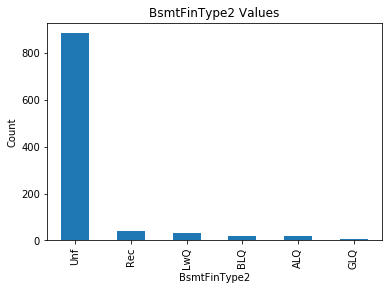

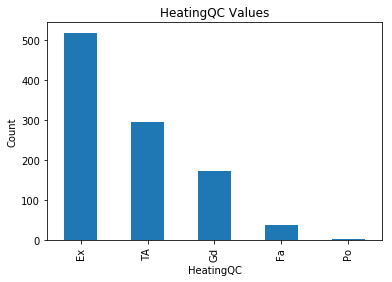

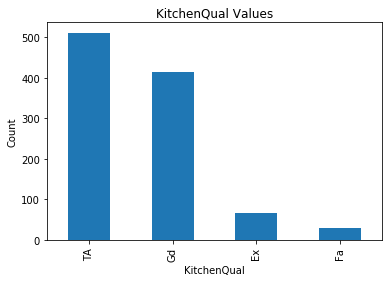

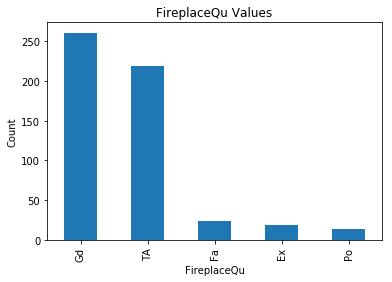

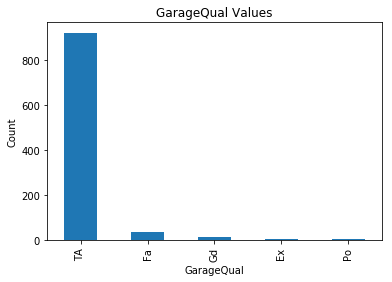

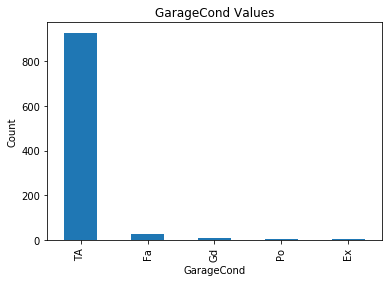

In [45]:
for col in ordinal_cols:
    col_data = ordinal_features[col]
    ax = col_data.value_counts().plot(kind='bar')
    ax.set_title('{} Values'.format(col))
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    plt.show()

With the ordinal data, there seems to be a few where there is a clear and very dominant value. Features include:

* `GarageCond`
* `GarageQual`
* `BsmtFinType2`
* `BsmtCond`
* `ExterCond`

As with the numeric values, I will remove these from the final model

In [46]:
cols_to_remove = ['GarageCond', 'GarageQual', 'BsmtFinType2', 'BsmtCond', 'ExterCond']
ordinal_features_v2 = ordinal_features.copy()
ordinal_features_v2.drop(cols_to_remove, axis=1, inplace=True)

In [47]:
ordinal_cols_v2 = ordinal_features_v2.columns.tolist()

In [48]:
# Finding out how many are null
ordinal_features_v2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1022 entries, 135 to 1126
Data columns (total 8 columns):
LotShape        1022 non-null object
ExterQual       1022 non-null object
BsmtQual        996 non-null object
BsmtExposure    996 non-null object
BsmtFinType1    996 non-null object
HeatingQC       1022 non-null object
KitchenQual     1022 non-null object
FireplaceQu     535 non-null object
dtypes: object(8)
memory usage: 71.9+ KB


In [49]:
ordinal_features_v2[ordinal_features_v2.BsmtQual.isna()].head(3)

,LotShape,ExterQual,BsmtQual,BsmtExposure,BsmtFinType1,HeatingQC,KitchenQual,FireplaceQu
156,Reg,TA,NaN,NaN,NaN,TA,TA,NaN
778,Reg,TA,NaN,NaN,NaN,TA,TA,TA
705,Reg,Fa,NaN,NaN,NaN,Fa,Fa,NaN


Since the Basement (Bsmt) features are all NaN together, I will impute the basement features with N/A since the house may not have a Basement.

For Fireplace Quality (FireplaceQu), I will also impute this N/A since a fireplace may not be there.

In [50]:
ordinal_pipeline_v2 = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='None')),
    ('ordinal', OrdinalEncoder())
])

processing_pipeline_v3 = ColumnTransformer([
    ('numeric', numeric_pipeline_v2, numeric_cols_v2),
    ('ordinal', ordinal_pipeline_v2, ordinal_cols_v2),
    ('categorical', categorical_pipeline, categorical_cols)
])

In [51]:
X_train_processed_v3 = processing_pipeline_v3.fit_transform(X_train)

In [52]:
scores = cross_val_regression(transformer, X_train_processed_v3, y_train)
print('Random Forest Pipeline V3 RMSE: {:.6f}'.format(scores['rmse']))
print('Random Forest Pipeline V3 features RMSLE: {:6f}'.format(scores['rmlse']))

Random Forest Pipeline V3 RMSE: 31773.071807
Random Forest Pipeline V3 features RMSLE: 0.151479


From imputing the Ordinal features with None and remove domiant ordinal features we have improved the overall result by a small bit.

### Categorical Features

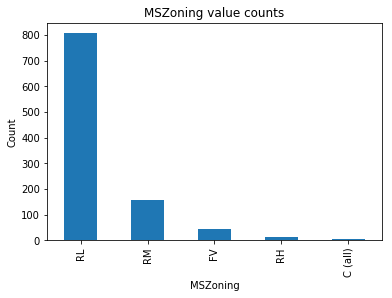

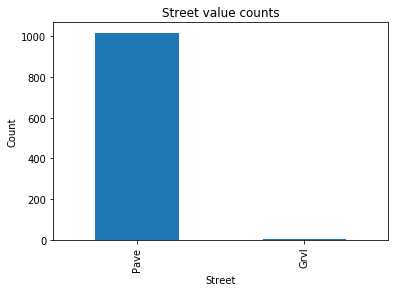

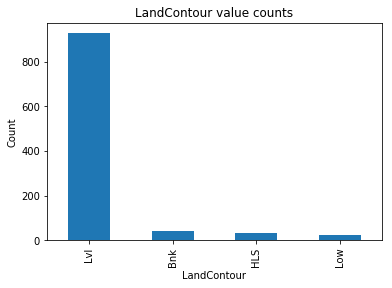

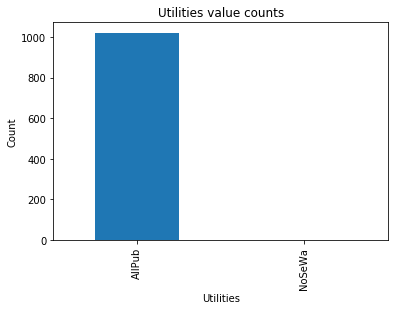

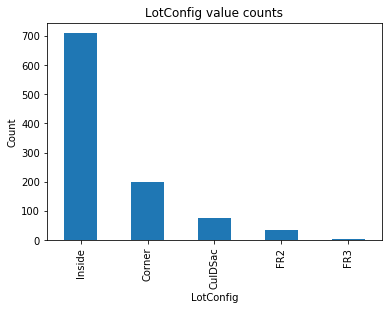

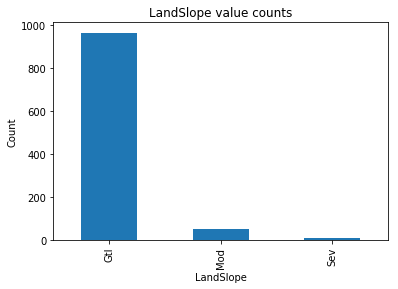

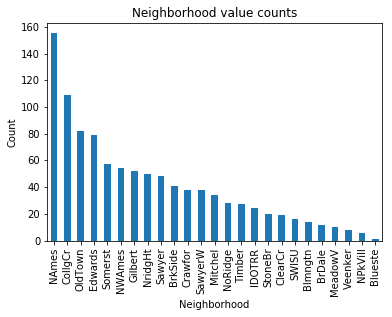

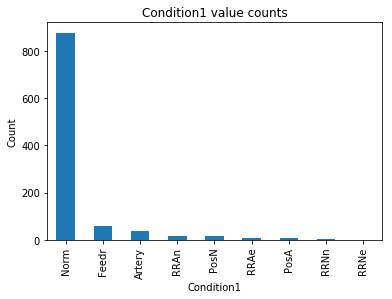

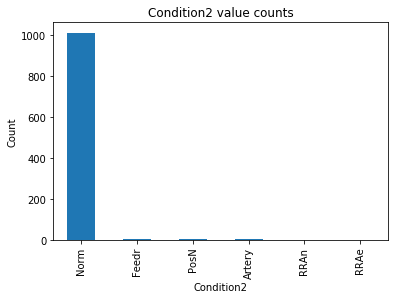

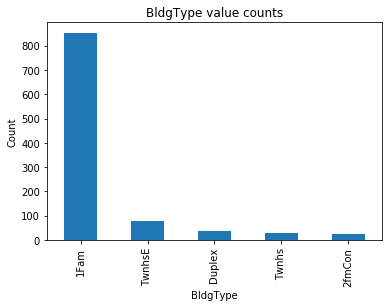

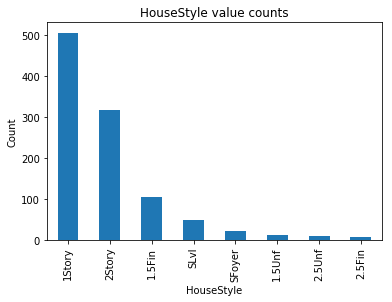

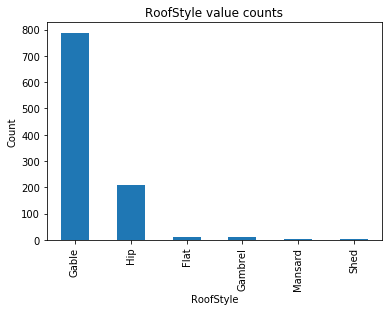

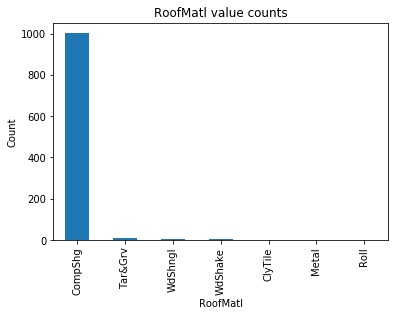

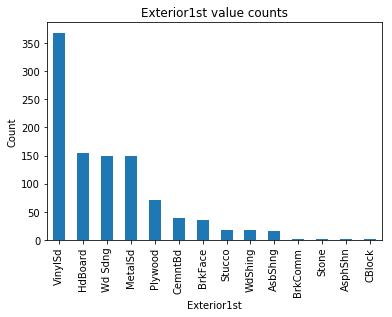

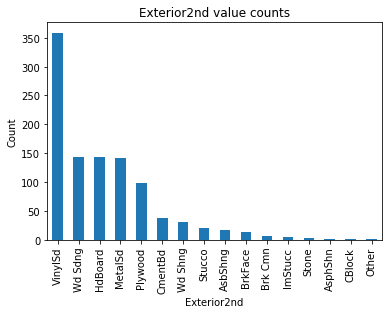

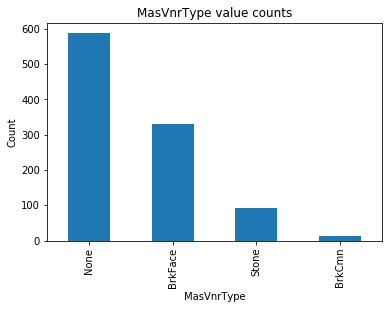

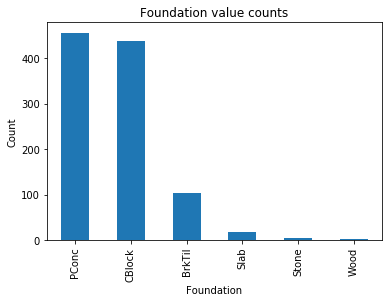

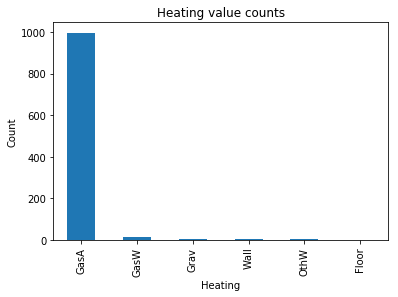

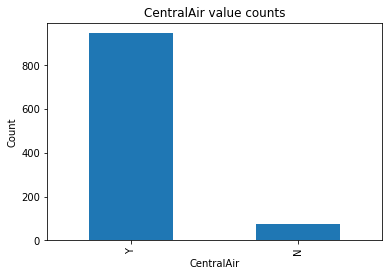

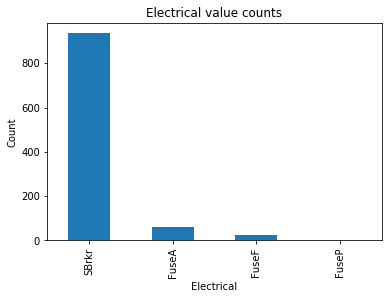

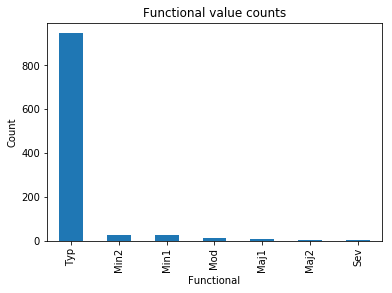

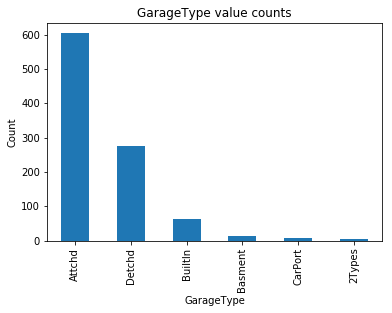

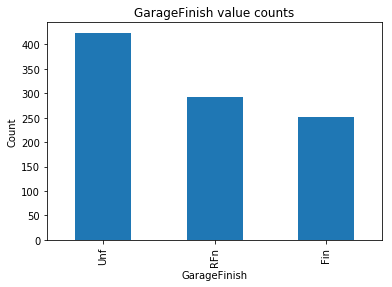

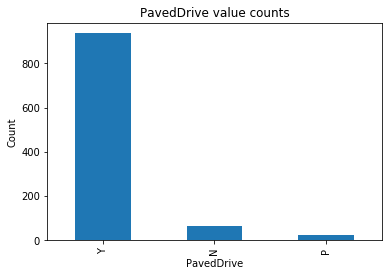

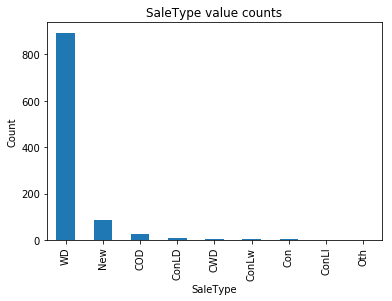

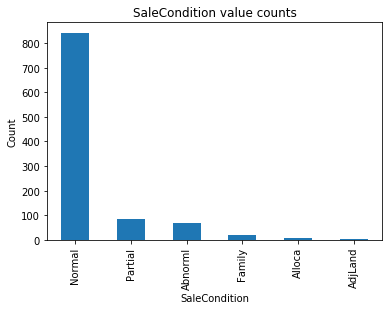

In [53]:
for col in categorical_cols:
    col_data = categorical_features[col]
    ax = col_data.value_counts().plot(kind='bar')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.set_title('{} value counts'.format(col))
    plt.show()

Again as before, I will remove features with very dominant values:

* `SaleCondition`
* `SaleType`
* `PavedDrive`
* `Functional`
* `Electrical`
* `CentralAir`
* `Heating`
* `RoofMatl`
* `Condition1`
* `Condition2`
* `Street`
* `Utilities`

In [54]:
cols_to_remove = [
    'SaleCondition',
    'SaleType',
    'PavedDrive',
    'Functional',
    'Electrical',
    'CentralAir',
    'Heating',
    'RoofMatl',
    'Condition1',
    'Condition2',
    'Street',
    'Utilities'
]

categorical_features_v2 = categorical_features.copy()
categorical_features_v2.drop(cols_to_remove, axis=1, inplace=True)
categorical_features_v2.shape

(1022, 14)

In [55]:
# Looking for null values
categorical_features_v2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1022 entries, 135 to 1126
Data columns (total 14 columns):
MSZoning        1022 non-null object
LandContour     1022 non-null object
LotConfig       1022 non-null object
LandSlope       1022 non-null object
Neighborhood    1022 non-null object
BldgType        1022 non-null object
HouseStyle      1022 non-null object
RoofStyle       1022 non-null object
Exterior1st     1022 non-null object
Exterior2nd     1022 non-null object
MasVnrType      1019 non-null object
Foundation      1022 non-null object
GarageType      968 non-null object
GarageFinish    968 non-null object
dtypes: object(14)
memory usage: 119.8+ KB


With the Garagetype and GarageFinish, I will impute these as None as this seems to be a case of a house not having a garage

In [62]:
categorical_features_v2[categorical_features_v2.MasVnrType.isna()]

,MSZoning,LandContour,LotConfig,LandSlope,Neighborhood,BldgType,HouseStyle,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,GarageType,GarageFinish
1278,RL,Lvl,Inside,Gtl,CollgCr,1Fam,2Story,Gable,VinylSd,VinylSd,NaN,PConc,Attchd,RFn
234,RL,Lvl,Inside,Gtl,Gilbert,1Fam,2Story,Gable,VinylSd,VinylSd,NaN,PConc,BuiltIn,Fin
977,FV,Lvl,Inside,Gtl,Somerst,TwnhsE,1Story,Gable,VinylSd,VinylSd,NaN,PConc,Attchd,Fin


In [63]:
categorical_features_v2.MasVnrType.value_counts()

None       587
BrkFace    329
Stone       91
BrkCmn      12
Name: MasVnrType, dtype: int64

To impute missing `MasVnrType` (Masonry veneer type), I will mark them as None as there is already a value there.

In [56]:
categorical_cols_v2 = categorical_features_v2.columns.tolist()

In [57]:
# Create a v4 pipeline

categorical_pipeline_v2 = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='None')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])

processing_pipeline_v4 = ColumnTransformer([
    ('numeric', numeric_pipeline_v2, numeric_cols_v2),
    ('ordinal', ordinal_pipeline_v2, ordinal_cols_v2),
    ('categorical', categorical_pipeline_v2, categorical_cols_v2)
])

In [58]:
X_train_processed_v4 = processing_pipeline_v4.fit_transform(X_train)

In [59]:
scores = cross_val_regression(transformer, X_train_processed_v4, y_train)
print('Random Forest Pipeline V4 RMSE: {:.6f}'.format(scores['rmse']))
print('Random Forest Pipeline V4 features RMSLE: {:6f}'.format(scores['rmlse']))

Random Forest Pipeline V4 RMSE: 32044.531895
Random Forest Pipeline V4 features RMSLE: 0.152680


The new model has gained a small increase in error, suggesting we have lost a bit too much information from the categorical features.

### Apply Grid Search to the model

In [68]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'n_estimators': [100, 150, 200, 250, 300, 350, 400],
        'criterion': ['mse', 'mae'],
        'warm_start': [True , False]
    }
]

grid_search_v1 = GridSearchCV(rand_forest, param_grid, cv=3, verbose=2, n_jobs=4, scoring='neg_mean_squared_log_error')
grid_search_v1.fit(X_train_processed_v4, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   20.5s
[Parallel(n_jobs=4)]: Done  84 out of  84 | elapsed:  4.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [70]:
np.sqrt(-grid_search_v1.best_score_)

0.15277576592356185

In [71]:
grid_search_v1.best_params_

{'criterion': 'mse', 'n_estimators': 400, 'warm_start': True}

Grid search reached the highest n_estimators argument, so will do a second round to make sure that additional improvements cannot be made.

In [72]:
param_grid = [
    {
        'n_estimators': [400, 450, 500, 550, 600],
        'criterion': ['mse', 'mae'],
        'warm_start': [True , False]
    }
]

grid_search_v2 = GridSearchCV(rand_forest, param_grid, cv=3, verbose=2, n_jobs=4, scoring='neg_mean_squared_log_error')
grid_search_v2.fit(X_train_processed_v4, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  6.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [75]:
grid_search_v2.best_params_

{'criterion': 'mse', 'n_estimators': 400, 'warm_start': True}

From running the grid search again, we can see that we reached the best result previously.

In [77]:
grid_search_best_v1 = grid_search_v1.best_estimator_

In [78]:
def create_scaled_model(regressor):
    return TransformedTargetRegressor(regressor=regressor,
                                        func=np.log1p, inverse_func=lambda x: np.exp(x) - 1)


best_model_v1 = create_scaled_model(grid_search_best_v1)

In [80]:
scores = cross_val_regression(best_model_v1, X_train_processed_v4, y_train)
print('Random Forest Grid Search V1 RMSE: {:.6f}'.format(scores['rmse']))
print('Random Forest Grid Search V1 features RMSLE: {:6f}'.format(scores['rmlse']))

Random Forest Grid Search V1 RMSE: 31727.505819
Random Forest Grid Search V1 features RMSLE: 0.150736


An improvement compared to the previous appraoches has been made in RMSE and RMSLE results. Now I will try a applying PCA to see if the number of featues could be reduced

In [85]:
from sklearn.decomposition import PCA

pca = PCA(random_state=RANDOM_STATE, n_components=0.99)
X_train_pca = pca.fit_transform(X_train_processed_v4)

In [86]:
scores = cross_val_regression(best_model_v1, X_train_pca, y_train)
print('Random Forest PCA RMSE: {:.6f}'.format(scores['rmse']))
print('Random Forest PCA Search V1 features RMSLE: {:6f}'.format(scores['rmlse']))

Random Forest PCA RMSE: 45377.077263
Random Forest PCA Search V1 features RMSLE: 0.224479


Applying PCA has significantly reduce the performance of the model. So for now I will keep all the features.

### Creating  a full pipeline

In [88]:
best_parameters = grid_search_best_v1.get_params()
best_parameters

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': True}

In [102]:
class TargetTransformers(object):
    @staticmethod
    def log(val):
        return np.log1p(val)
    
    @staticmethod
    def inverse_log(val):
        return np.exp(val) - 1

In [117]:
ordinal_features_missing_cols = [
    'BsmtQual',
    'BsmtExposure',
    'BsmtFinType1',
    'FireplaceQu'
]

In [119]:
all_ordinal_cols_v2 = ordinal_features_v2.columns

ordinal_cols_non_missing = all_ordinal_cols_v2[
    ~all_ordinal_cols_v2.isin(ordinal_features_missing_cols)
].tolist()

In [123]:
ordinal_pipeline_pt1 = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='None')),
    ('encoder', OrdinalEncoder())
])

ordinal_pipeline_pt2 = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

ml_pipeline_v1 = Pipeline([
    ('processing', ColumnTransformer([
        ('numeric', numeric_pipeline_v2, numeric_cols_v2),
        ('ordinal_pt1', ordinal_pipeline_pt1, ordinal_features_missing_cols),
        ('ordinal_pt2', ordinal_pipeline_pt2, ordinal_cols_non_missing),
        ('categorical', categorical_pipeline_v2, categorical_cols_v2)
    ])),
    ('model', TransformedTargetRegressor(regressor=RandomForestRegressor(**best_parameters),
                                        func=TargetTransformers.log, inverse_func=TargetTransformers.inverse_log))
])

In [125]:
ml_pipeline_v1 = ml_pipeline_v1.fit(X_train, y_train)

### Trying it on the test set

In [126]:
y_pred = ml_pipeline_v1.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
rmsle = root_mean_log_error(y_test, y_pred)

print('Test RMSE: {:.6f}'.format(rmse))
print('Test RMSLE: {:.6f}'.format(rmsle))

Test RMSE: 26983.538135
Test RMSLE: 0.138489


### Saving the model

In [129]:
import joblib
from datetime import datetime

date = datetime.now().strftime('%d_%m_%Y')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
model_name = 'house_prices_model_v3_{}.joblib'.format(date)
full_model_path = os.path.join(MODEL_PATH, model_name)

# joblib.dump(ml_pipeline_v1, full_model_path)

['C:\\Users\\Ryan\\Documents\\Development\\Data Science\\ml-house-prices\\models\\house_prices_model_v3_31_08_2020.joblib']

## Creating a submission with the model

In [131]:
TEST_DATA = os.path.join(DATA_PATH, 'test.csv')

test_data = pd.read_csv(TEST_DATA)

In [138]:
prediction = ml_pipeline_v1.predict(test_data)
ids = test_data['Id']

submission_data = {
    'Id': ids,
    'SalePrice': prediction
}

submission_file = os.path.join(DATA_PATH, 'submission_v2.csv')
submussion_df = pd.DataFrame.from_dict(submission_data)
# submussion_df.to_csv(submission_file, index=False)

Submission v2 got a score of 0.14999 compared to the first version of 0.16962. So we have an improved model

## Regression Stacking

Applying stacking multiple algorithms to see how that improves the overall results. First trying a bunch of other classification algorithms to see which ones should be used

In [143]:
from sklearn.svm import SVR, NuSVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor


clfs = [
    SVR(),
    NuSVR(),
    ExtraTreesRegressor(random_state=RANDOM_STATE),
    KNeighborsRegressor(),
    MLPRegressor(random_state=RANDOM_STATE)
]

for idx, clf in enumerate(clfs):
    print('{} Training {}'.format(idx, clf.__class__.__name__))
    scores = cross_val_regression(clf, X_train_processed_v4, y_train)
    print('RMSE: {:.4f}, RMSLE: {:.4f}'.format(scores['rmse'], scores['rmlse']))

0 Training SVR
RMSE: 79201.5209, RMSLE: 0.3941
1 Training NuSVR
RMSE: 77992.0252, RMSLE: 0.3947
2 Training ExtraTreesRegressor
RMSE: 30245.0555, RMSLE: 0.1515
3 Training KNeighborsRegressor
RMSE: 47062.6776, RMSLE: 0.2374
4 Training MLPRegressor


c:\users\ryan\documents\development\data science\ml-house-prices\env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\ryan\documents\development\data science\ml-house-prices\env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\ryan\documents\development\data science\ml-house-prices\env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\ryan\documents\development\data science\ml-house-prices\env\lib\site-packages\sklearn\neural_netw

RMSE: 193588.2477, RMSLE: 3.7680


c:\users\ryan\documents\development\data science\ml-house-prices\env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [146]:
from sklearn.ensemble import StackingRegressor

stack_reg = StackingRegressor([
    ('extra_rf', ExtraTreesRegressor(random_state=RANDOM_STATE)),
    ('rf', RandomForestRegressor(**best_parameters)),
    ('svr', SVR())
])

scores = cross_val_regression(stack_reg, X_train_processed_v4, y_train)
print('Stacking Regressors RMSE: {:.6f}'.format(scores['rmse']))
print('Stacking Regressors RMSLE: {:6f}'.format(scores['rmlse']))

Stacking Regressors RMSE: 29659.204814
Stacking Regressors RMSLE: 0.146602


Stacking multiple regression models has resulted in a significant improvement in both RMSE and RMSLE error functions. I will now try to optimize the ExtraTrees and SVR models